# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [17]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
# train & test data are downloaded into the datasets folder
training_file = 'Datasets/train.p'
testing_file = 'Datasets/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [18]:
### Replace each question mark with the appropriate value.
# Import Python dependencieis
import numpy as np

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[1])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [19]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import pandas as pd
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline


In [20]:
#Explore the signname table first
sign_table=pd.read_csv("signnames.csv")
print("We have",len(sign_table),"sign labels in this table.","\nHere are some examples:")
sign_table.head()

We have 43 sign labels in this table. 
Here are some examples:


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


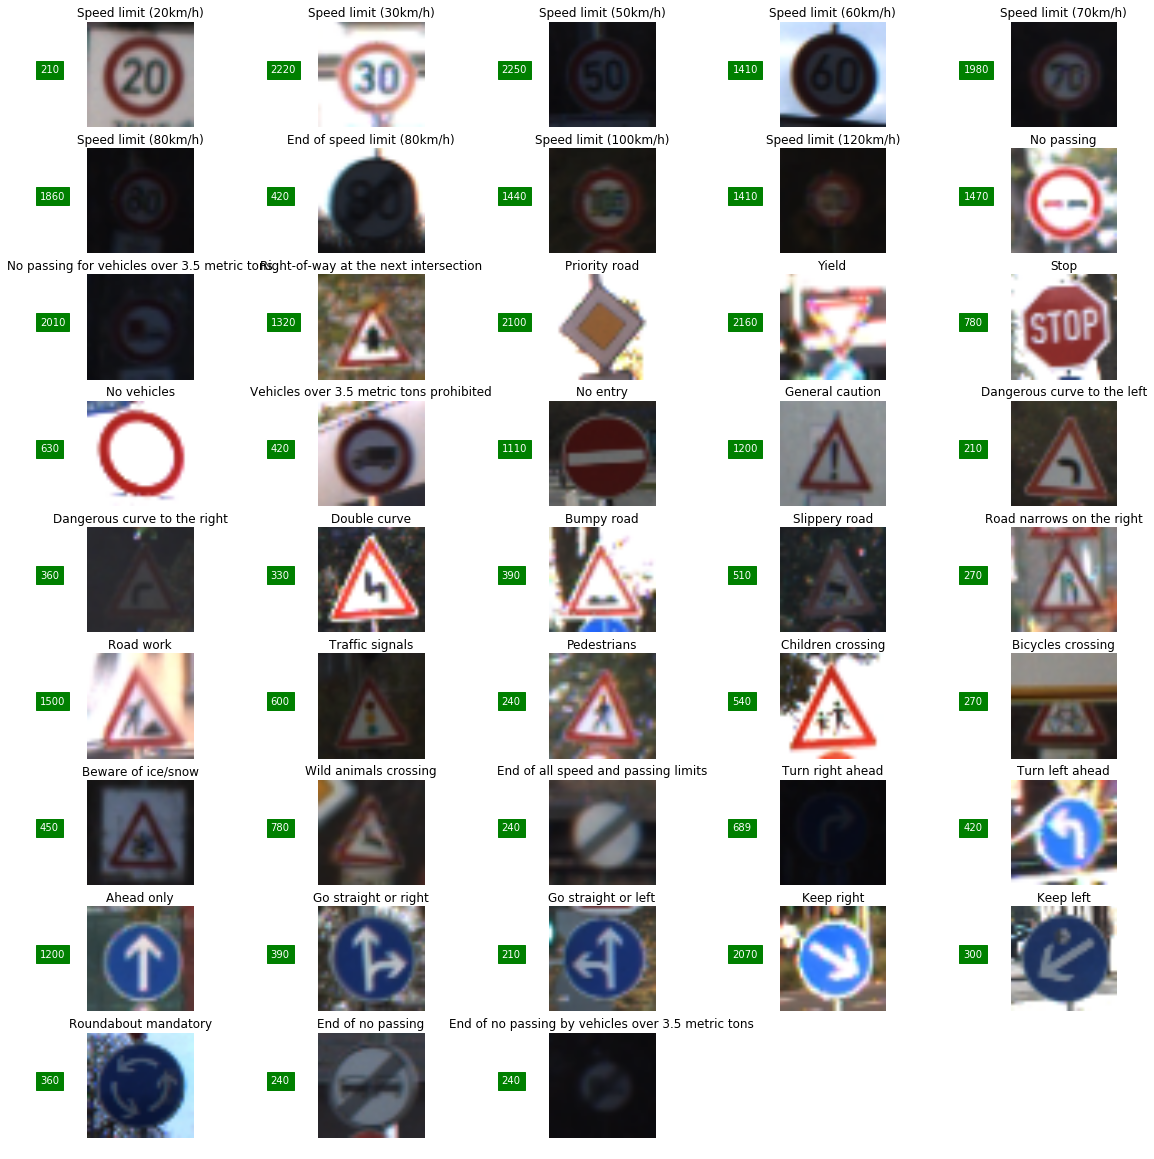

In [21]:
#Investigate a random image of each sign
import random

sign_names=sign_table['SignName'].tolist()
for idex, name in enumerate(sign_names):
    group=np.where(y_train == idex)[0]
    gnum=len(group)
    ind=random.randint(0, gnum)
    img = X_train[group[ind]]
    plt.subplot(9, 5, idex + 1)
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.text(-15, 15, str(gnum),backgroundcolor='g',color='w')
    
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

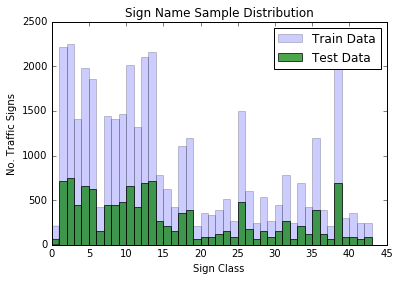

In [22]:
#Investigate the class distribution of sign names 
bins = np.linspace(0, 43, 44)
plt.xlabel('Sign Class')
plt.ylabel('No. Traffic Signs')
plt.title("Sign Name Sample Distribution")
plt.hist(y_train,bins,alpha=0.2,label=['Train Data'])
plt.hist(y_test,bins,alpha=0.7,label=['Test Data'])
plt.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [23]:
import sklearn
print("Scikit-Learn", sklearn.__version__)

Scikit-Learn 0.18.1


In [24]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

def cal_mean_std(data):
    mean_std=[[np.mean(data[:, :, :, i]),np.std(data[:, :, :, i])] for i in range(0,3)]
    return mean_std

def data_norm(data, mean_std):
    data_norm = data.copy().astype(np.float32)
    for i in range(0,3):
        data_channel_i=data_norm[:, :, :, i]
        data_norm[:, :, :, i]=(data_channel_i - mean_std[i][0])/mean_std[i][1]
        
    return data_norm

def onehot(ylabel,nclass):
    label_onehot = np.zeros((ylabel.shape[0], nclass), dtype=np.float32)
    label_onehot[np.arange(ylabel.shape[0]), ylabel] = 1.0
    return label_onehot

#start converting data into 0 mean & 1 variance
train_mean_std=cal_mean_std(X_train)
X_train_norm = data_norm(X_train, train_mean_std)
X_test_norm = data_norm(X_test, train_mean_std)
y_test_1hot = onehot(y_test,43)
y_train_1hot = onehot(y_train,43)

X_test_norm, X_eval_norm, y_test_1hot, y_eval_1hot = train_test_split(X_test_norm, y_test_1hot, test_size=0.2, random_state=0)
print('Training:', X_test_norm.shape, y_test_1hot.shape)
print('Validation:', X_eval_norm.shape, y_eval_1hot.shape)
print('Testing:', X_test.shape, onehot(y_test,43).shape)


Training: (10104, 32, 32, 3) (10104, 43)
Validation: (2526, 32, 32, 3) (2526, 43)
Testing: (12630, 32, 32, 3) (12630, 43)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I am following a very typical(I mean, conventional) data pre-processing standardization: 
1. Normalize data into zero-mean & unit-variance
2. Split the whole dataset into training dataset, validation dataset and testing dataset.

The standardization of zero-mean & unit-variance is used largely because many elements in the objective function 
of a learning algorithm pre-assume that all features are zero-centered and have variance in the same order. But this
is not the case for all scenarios.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Based on the class distribution analysis of sign names earlier in this notebook, I found the the original training dataset is around 3.5 times of the testing data(almost an 80/20 split). Since my parameter estimates might have greater variances with less training data, I also choose an 80/20 rule to split the training dataset into training dataset & validation set.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [2]:
### Train your model here.
### Feel free to use as many code cells as needed.

#Initialization
import tensorflow as tf
batch_size = 64
num_steps = 200

In [30]:
#Function pre-defined

def conv_layer(input_layer, shape_size, output_size):
    W = tf.Variable(tf.truncated_normal([3, 3, shape_size, output_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[output_size]))
    
    conv = tf.nn.conv2d(input_layer, W, strides=[1, 1, 1, 1], padding='SAME') + b
    return tf.nn.relu(conv)

def pool_layer(input_layer):
    return tf.nn.max_pool(input_layer, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME")

def fc_layer(input_layer, shape_size, output_size):
    W = tf.Variable(tf.truncated_normal([shape_size, output_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[output_size]))
    
    return tf.nn.relu(tf.matmul(input_layer, W) + b)

def cnn_layer(x):
    conv_1 = conv_layer(x, 3, 32)
    pool_1 = pool_layer(conv_1) 
    conv_2 = conv_layer(pool_1, 32, 64)
    pool_2 = pool_layer(conv_2)
    pool_2_flat = tf.reshape(pool_2, [-1, 8 * 8 * 64])
    fc_1 = fc_layer(pool_2_flat, 8 * 8 * 64, 1024)
    fc_2 = fc_layer(fc_1, 1024, 43)
    return fc_2


In [ ]:
#Running the session
x = tf.placeholder("float", shape=[None, 32, 32, 3])
y = tf.placeholder("float", shape=[None, 43])

y_ = cnn_layer(x)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_, y))
adam_train = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_steps):
        print("This is ", epoch, " epoch.")
        random_perm = np.random.permutation(X_train_norm.shape[0])
        X_train_norm = X_train_norm[random_perm]
        y_train_1hot = y_train_1hot[random_perm]
        for step in range(X_train_norm.shape[0] // batch_size):
            batch_begin = step * batch_size
            batch_end=batch_begin+batch_size
            X_batch = X_train_norm[batch_begin:batch_end]
            y_batch = y_train_1hot[batch_begin:batch_end]
            sess.run(adam_train,feed_dict = {x: X_batch,y: y_batch})

eval_accuracy = sess.run(accuracy, feed_dict = {x: X_eval_norm, y: y_eval_1hot})
print(eval_accuracy)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I am using AdamOptimizer, a SGD algorithm in which the gradient used in each iteration updated from the previous using a technique based in momentum. It seems one of the best method to quickly adjust steps & attains the global minimux, if converge.

I set total epochs as 200, although small, because it works only slightly different a bigger number choice like 500 or 1000 in my case. But during my deep learning study in modeling Mnist, for example, it makes a huge difference between using 200 and 500.

I set batch size as 64, because it seems like a good fit for the image size of this dataset, and honestly speaking, seems like working ok.

The strucuture of my neural network is as following:
Input -> conv layers -> pool layers -> another conv layers -> pool layers -> fully connected layers -> another fully connected layers


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The main blockers I encountered as I started on this project is the structure of the neural networks. I can either follow a very traditional structure(like the one used in Mnist example in tensorflow documentation) or try some thing new. I was not sure why pool function & ReLU works in the context of building up a neural network, and therefore having been experenced a tedious process of trail and error is the only way to understand it deeper.
Another issue I come up with is that, is it true that the deeper the layers the better the model will be. as well as epoch, batch_size and other initial values we set. Too many parameters to explore their real roles in deep learning.

Also, performance is another big issue. I found that even my model is tuned around acceptable, but it runs really really slow. Due to very limited spare time that I have and I am very new to AWS, I still need to use GPU in AWS to re-run my model and see how faster it will be.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.